In [1]:
import xgboost as xgb
from xgboost import XGBClassifier 
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, auc

from sklearn.svm import SVC

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

import auxiliaries as aux

### Usefull Functions ###

In [2]:
import auxiliaries as aux

### Read Data, Train-Eval-Split ###

In [3]:
# read the csv-files and take the respondent_id column as index:

X_train_df = pd.read_csv("training_set_features.csv", index_col="respondent_id")
y_train_df = pd.read_csv("training_set_labels.csv", index_col="respondent_id")
X_test_df = pd.read_csv("test_set_features.csv", index_col="respondent_id")

X_train_df.shape, X_test_df.shape
# Output:
# ((26707, 36), (26708, 36))


((26707, 35), (26708, 35))

In [4]:
random_seed = 11
test_size = 0.2
X_train, X_eval, y_train, y_eval = train_test_split(X_train_df, y_train_df, test_size=test_size, random_state=random_seed)

In [5]:
y_train.values

array([[1, 1],
       [0, 1],
       [0, 0],
       ...,
       [0, 0],
       [1, 1],
       [1, 1]], dtype=int64)

### Data Preprocessing with Category Encoding ###

#### Category Encoding ####

In [6]:
# transform the two independent binary labels to a categorial output:

label_number_to_categories = { 0: "not vaccinated", 1: "only seasonal", 2 : "only h1n1", 3 : "seasonal and h1n1"}
label_number_to_multilabel = { 0: [0,0], 1: [0,1], 2 : [1,0], 3 : [1,1] }

def multiLableTocategory(l):
    if np.array_equal(l, [0,0]):
        return 0
    if np.array_equal(l,[0,1]):
        return 1
    if np.array_equal(l, [1,0]):
        return 2
    if np.array_equal(l, [1,1]):
        return 3

y_train_cat = np.array([multiLableTocategory(yt) for yt in y_train.values])
y_eval_cat = np.array([multiLableTocategory(yt) for yt in y_eval.values])

#### Preprocessing Pipeline ####
We want to transform numeric and non-numeric columns differently in the sequel, so we separate them here:

In [7]:
# we want to transform numeric and non-numeric columns differently in the sequel, so we separate them here:
num_cols = X_train_df.columns[X_train_df.dtypes != "object"].values
non_numeric_columns = X_train_df.columns[X_train_df.dtypes == "object"].values

#### Note on the non-numeric columns ####
The non-numeric columns contain at least 2 columns that might have a relevant ordering property: age_group and education. <br>
These could be encoded as categories, not as one-hot, to preserve the ordering structure.

In [8]:
non_numeric_columns

array(['age_group', 'education', 'race', 'sex', 'income_poverty',
       'marital_status', 'rent_or_own', 'employment_status',
       'hhs_geo_region', 'census_msa', 'employment_industry',
       'employment_occupation'], dtype=object)

In [9]:
from sklearn.model_selection import GridSearchCV

preprocessor = ColumnTransformer(
    transformers = [
        ("numeric", SimpleImputer(strategy="most_frequent"), num_cols),
        ("ohe_non_num", OneHotEncoder(), non_numeric_columns)
    ],
    remainder="drop" # drop all non-numeric columns from the data
)


In [10]:
X_train_preprocessed = preprocessor.fit_transform(X_train)

## GridSearchCV on Multiclass-Output XGBClassifier ##

#### GridSearchCV ####

In [11]:
from sklearn.model_selection import StratifiedKFold

model = XGBClassifier(use_label_encoder=False, eval_metric="error")

#n_estimators = [200, 400, 800, 1500, 2000]
#max_depth = [2, 4, 6, 8]
#param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)
#---
#n_estimators = [200, 400, 800, 1500, 2000]
#subsample = np.arange(0.1, 1.1, 0.1)
#param_grid = dict(subsample=subsample, n_estimators=n_estimators)
#---
#subsample = np.arange(0.1, 1.1, 0.1)
#param_grid = dict(subsample=subsample)
#---
#n_estimators = [200, 400, 800, 1500, 2000]
#learning_rate = [0.00001, 0.0001, 0.001, 0.01, 0.1, 0.5]
#param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators)
#---
#n_estimators = [4000, 5000, 8000]
#learning_rate = [0.00001, 0.0001, 0.001, 0.01]
#param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators)
#---
#colsample_bylevel = np.arange(0.1, 1.1, 0.1)
#param_grid = dict(colsample_bylevel=colsample_bylevel)
#---
#subsample = np.arange(0.1, 1.1, 0.1)
#colsample_bylevel = np.arange(0.1, 1.1, 0.1)
#param_grid = dict(subsample=subsample, colsample_bylevel=colsample_bylevel)
#---
#n_estimators = [200, 400, 800, 1500, 2000]
#colsample_bylevel = np.arange(0.1, 1.1, 0.1)
#param_grid = dict(colsample_bylevel=colsample_bylevel, n_estimators=n_estimators)
#---
n_estimators = [200, 400, 800, 1500, 2000]
colsample_bylevel = np.arange(0.1, 1.1, 0.1)
learning_rate = [0.001, 0.01, 0.1]
param_grid = dict(colsample_bylevel=colsample_bylevel, learning_rate=learning_rate, n_estimators=n_estimators)
#---

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=11)

# use cpu for training:
#grid_search = GridSearchCV(model, param_grid=param_grid, scoring='neg_log_loss', cv=kfold, n_jobs=-1)

# use gpu for training:
model_gpu = XGBClassifier(use_label_encoder=False, eval_metrics="error", tree_method='gpu_hist')
grid_search = GridSearchCV(model_gpu, param_grid=param_grid, scoring="neg_log_loss", cv=kfold, n_jobs=-1)

In [14]:
# training on a four-class output:

grid_result = grid_search.fit(X_train_preprocessed, y_train_cat)

print(f"{grid_result.best_score_}")

time: 139m14.9s <br>
Best: -0.7727140560084045 using: {'colsample_bylevel': 0.1, 'learning_rate': 0.1, 'n_estimators': 400} <br>

#### Compare CPU vs GPU Training for a Simple Case #### 
colsample_bylevel = np.arange(0.1, 1.1, 0.1) <br>
param_grid = dict(colsample_bylevel=colsample_bylevel) <br>
<br>
1. cpu: 1m21.1 : -0.7835174773362693 <br>
2. gpu: 1m19.3s : -0.7835702071825542 <br>
3. cpu: 25.2s :-0.7835174773362693 <br>
4. gpu: 1m2.7s : -0.7835702071825542 <br>
5. gpu: 1m1.2s : -0.7835702071825542 <br>

In [13]:
from matplotlib import pyplot

print(f"Best: {grid_result.best_score_} using: {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for m, s, p in zip(means, stds, params):
    print(f"{m} : {s} : {p}")


NameError: name 'grid_result' is not defined

In [19]:
#scores = np.array(means).reshape(len(subsample), len(n_estimators))
scores = np.array(means).reshape( len(learning_rate), len(n_estimators))
for i,d in enumerate(learning_rate):
    pyplot.plot(n_estimators, scores[i], label="learning_rate = " + str(d))
pyplot.legend()
pyplot.title("XGBoost n_estimators by learning_rate" + f"Best: {grid_result.best_score_:.4f} using: {grid_result.best_params_}")
pyplot.ylabel("Neg Log loss")
pyplot.xlabel("n_estimators")
pyplot.show()

NameError: name 'means' is not defined

### List of Experiments ###

#### Gridsearch with "max_depth" and "n_estimators" with: ####
StratifiedKFold(n_splits=5, shuffle=True, random_state=11) <br>
<br>
n_estimators = [200, 400, 800, 1500, 2000] <br>
max_depth = [2, 4, 6, 8]<br>
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)<br>
<br>
resulted in the best parameters:<br>
max_depth=2  <br>
n_estimators=200 <br>

#### Gridsearch with "subsample" and "n_estimators" with: ####
StratifiedKFold(n_splits=5, shuffle=True, random_state=11) <br>
<br>
n_estimators = [200, 400, 800, 1500, 2000] <br>
subsample = np.arange(0.1, 1.1, 0.1)<br>
param_grid = dict(subsample=subsample, n_estimators=n_estimators)<br>
<br>
resulted in the best parameters:<br>
subsample=1.0  <br>
n_estimators=200 <br>
<br>
best neg_log_loss:  > -0.80

#### Gridsearch with "learning_rate" and "n_estimators" with: ####
StratifiedKFold(n_splits=5, shuffle=True, random_state=11) <br>
<br>
n_estimators = [200, 400, 800, 1500, 2000] <br>
learning_rate = [0.00001, 0.0001, 0.001, 0.01, 0.1, 0.5] <br>
param_grid = dict(subsample=subsample, n_estimators=n_estimators)<br>
<br>
resulted in the best parameters:<br>
learning_rate = 0.01 <br>
n_estimators = 800 <br>
<br>
best neg_log_loss:  -0.7802690746682887

#### Feature Sampling by Split ####
Best: -0.7923793430614928 using: {'colsample_bylevel': 0.1}

#### Row-Sampling ####
Best: -0.8155262830900029 using: {'subsample': 0.9}

#### Gridsearch Feature-Sampling by Split and Row-Sampling ####

Best: -0.7923793430614928 using: {'colsample_bylevel': 0.1, 'subsample': 1.0}

#### Gridsearch Feature-Sampling by Split and n_estimators ####
Best: -0.8237915883049227 using: {'colsample_bylevel': 0.1, 'n_estimators': 200}

#### Gridsearch Learning-Rate vs n_estimators: ####
n_estimators = [2000, 3000, 4000] <br>
learning_rate = [0.00001, 0.0001, 0.001, 0.01] <br>
Best: -0.7900804630380882 using: {'learning_rate': 0.01, 'n_estimators': 2000}

#### Gridsearch Learnin-Rate vs n_estimators ####
n_estimators = [4000, 5000, 8000] <br>
learning_rate = [0.00001, 0.0001, 0.001, 0.01] <br>
Best: -0.7800877173473719 using: {'learning_rate': 0.001, 'n_estimators': 8000} <br>
Time: 42m33.8s


#### Gridsearch learning-rate, colsample_bylevel, n_estimators ####
n_estimators = [200, 400, 800, 1500, 2000] <br>
colsample_bylevel = np.arange(0.1, 1.1, 0.1) <br>
learning_rate = [0.001, 0.01, 0.1] <br>
Best: -0.7727140560084045 using: {'colsample_bylevel': 0.1, 'learning_rate': 0.1, 'n_estimators': 400} <br>
Time: 139m14.9s <br>
Roc-AUC: <br>
Seasonal: 0.8711313166637525 <br>
H1N1: 0.8764810738420332 <br>

### Prediction and Presentation AUC for Seasonal and H1N1 ###

In [20]:
X_eval_preprocessed = preprocessor.fit_transform(X_eval)
y_preds = grid_search.predict_proba(X_eval_preprocessed)

NotFittedError: This GridSearchCV instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [32]:
# example of probabilities for the four categories:
print(y_preds[0].sum(), y_preds[0])

1.0 [0.47577605 0.3791126  0.03844447 0.10666689]


In [33]:
# for this task we assume, that h1n1- and seasonal-vaccination are predicted independently, i.e. the case of both vaccinations, [1,1] counts for each 
# single case i.e. [0,1] and [1,0]:

y_pred_proba_seasonal = y_preds[:,1] + y_preds[:,3]
y_pred_proba_h1n1 = y_preds[:,2] + y_preds[:,3]

In [34]:
# peek at data-shapes:
y_eval.head(1)

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
18682,1,1


In [41]:
y_eval_h1n1 = y_eval.values[:,0]
y_eval_seasonal = y_eval.values[:,1]
roc_auc_score(y_eval_seasonal, y_pred_proba_seasonal), roc_auc_score(y_eval_h1n1, y_pred_proba_h1n1)

ValueError: Found input variables with inconsistent numbers of samples: [5342, 26708]

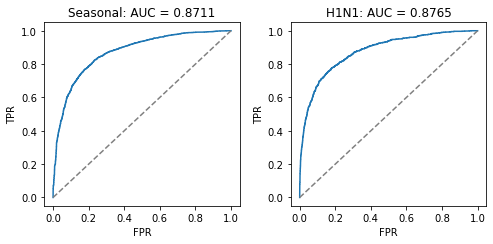

In [37]:
fig, ax = plt.subplots(1,2,figsize=(7, 3.5))
aux.plot_roc(y_eval_seasonal, y_pred_proba_seasonal, "Seasonal", ax=ax[0])
aux.plot_roc(y_eval_h1n1, y_pred_proba_h1n1, "H1N1", ax=ax[1])
fig.tight_layout()

### Retraining and Saving the Model ###

In [40]:
submission_data_filepath = "my_submission_learningrate_001_nestimators400_colsamplebylevel01_xgb_clf.csv"

y_train_df_cat = np.array([multiLableTocategory(yt) for yt in y_train_df.values])
X_train_transformed = preprocessor.fit_transform(X_train_df)

best_colsample_bylevel = grid_result.best_params_['colsample_bylevel']
best_learning_rate = grid_result.best_params_['learning_rate']
best_n_estimators = grid_result.best_params_['n_estimators']

model = XGBClassifier(
    use_label_encoder=False, 
    eval_metric="error", 
    learning_rate=best_learning_rate, 
    n_estimators=best_n_estimators, 
    colsample_bylevel=best_colsample_bylevel)

model.fit(X_train_transformed, y_train_df_cat)

X_test_prepro = preprocessor.fit_transform(X_test_df)
y_pred_test = model.predict_proba(X_test_prepro)
y_pred_proba_seasonal = y_pred_test[:,1] + y_pred_test[:, 3]
y_pred_proba_h1n1 = y_pred_test[:,2] + y_pred_test[:,3]

submission_df = pd.read_csv("submission_format.csv", index_col="respondent_id")
np.testing.assert_array_equal(submission_df.index.values, X_test_df.index.values)
submission_df["h1n1_vaccine"]=y_pred_proba_h1n1
submission_df["seasonal_vaccine"]=y_pred_proba_seasonal

submission_df.to_csv(submission_data_filepath, index=True)

### Using GPU for Final-Retraining and Submission ###

In [14]:
# using gpu 

submission_data_filepath = "my_submission_learningrate_001_nestimators8000_xgb_clf_gpu.csv"

y_train_df_cat = np.array([multiLableTocategory(yt) for yt in y_train_df.values])
X_train_transformed = preprocessor.fit_transform(X_train_df)

#best_colsample_bylevel = grid_result.best_params_['colsample_bylevel']
#best_learning_rate = grid_result.best_params_['learning_rate']
#best_n_estimators = grid_result.best_params_['n_estimators']

model_gpu = XGBClassifier(
    use_label_encoder=False,
    eval_metric="error", 
    learning_rate=best_learning_rate, 
    n_estimators=best_n_estimators, 
    tree_method='gpu_hist',
    gpu_id=0)

model_gpu.fit(X_train_transformed, y_train_df_cat)

X_test_prepro = preprocessor.fit_transform(X_test_df)
y_pred_test = model_gpu.predict_proba(X_test_prepro)
y_pred_proba_seasonal = y_pred_test[:,1] + y_pred_test[:, 3]
y_pred_proba_h1n1 = y_pred_test[:,2] + y_pred_test[:,3]

submission_df = pd.read_csv("submission_format.csv", index_col="respondent_id")
np.testing.assert_array_equal(submission_df.index.values, X_test_df.index.values)
submission_df["h1n1_vaccine"]=y_pred_proba_h1n1
submission_df["seasonal_vaccine"]=y_pred_proba_seasonal

submission_df.to_csv(submission_data_filepath, index=True)